<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 3. Наглядный пример регуляризации логистической регрессии


В 1 статье уже приводился пример того, как полиномиальные признаки позволяют линейным моделям строить нелинейные разделяющие поверхности. Покажем это в картинках.

Посмотрим, как регуляризация влияет на качество классификации на наборе данных по тестированию микрочипов из курса Andrew Ng по машинному обучению. 
Будем использовать логистическую регрессию с полиномиальными признаками и варьировать параметр регуляризации C.
Сначала посмотрим, как регуляризация влияет на разделяющую границу классификатора, интуитивно распознаем переобучение и недообучение.
Потом численно установим близкий к оптимальному параметр регуляризации с помощью кросс-валидации (`cross-validation`) и  перебора по сетке (`GridSearch`). 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

Загружаем данные с помощью метода `read_csv` библиотеки `pandas`. В этом наборе данных для 118 микрочипов (объекты) указаны результаты двух тестов по контролю качества (два числовых признака) и сказано, пустили ли микрочип в производство. Признаки уже центрированы, то есть из всех значений вычтены средние по столбцам. Таким образом, "среднему" микрочипу соответствуют нулевые значения результатов тестов.  

In [2]:
# загрузка данных
data = pd.read_csv('../../data/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


Посмотрим на первые и последние 5 строк.

In [3]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Сохраним обучающую выборку и метки целевого класса в отдельных массивах NumPy.

In [5]:
X = data.ix[:,:2].values
y = data.ix[:,2].values

Отобразим данные. Красный цвет соответствует бракованным чипам, зеленый – нормальным.  

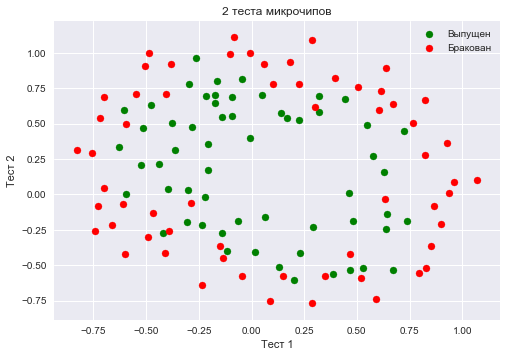

In [6]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов')
plt.legend();

Определяем функцию для отображения разделяющей кривой классификатора

In [7]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Полиномиальными признаками до степени $d$ для двух переменных $x_1$ и $x_2$ мы называем следующие:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

Например, для $d=3$ это будут следующие признаки:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Нарисовав треугольник Пифагора, Вы сообразите, сколько таких признаков будет для $d=4,5...$ и вообще для любого $d$.
Попросту говоря, таких признаков экспоненциально много, и строить, скажем, для 100 признаков полиномиальные степени 10 может оказаться затратно (а более того, и не нужно). 


Создадим объект `sklearn`, который добавит в матрицу $X$ полиномиальные признаки вплоть до степени 7.

In [8]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [9]:
X_poly.shape

(118, 36)

Обучим логистическую регрессию с параметром регуляризации $C = 10^{-2}$. Изобразим разделяющую границу.
Также проверим долю правильных ответов классификатора на обучающей выборке. Видим, что регуляризация оказалась 
слишком сильной, и модель "недообучилась".

Доля правильных ответов классификатора на обучающей выборке: 0.627


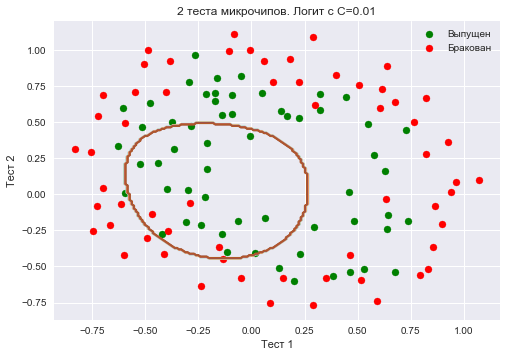

In [10]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Увеличим $C$ до 1. Тем самым мы *ослабляем* регуляризацию, теперь в решении значния весов логистической регрессии могут оказаться больше (по модулю), чем в прошлом случае. 

Доля правильных ответов классификатора на обучающей выборке: 0.831


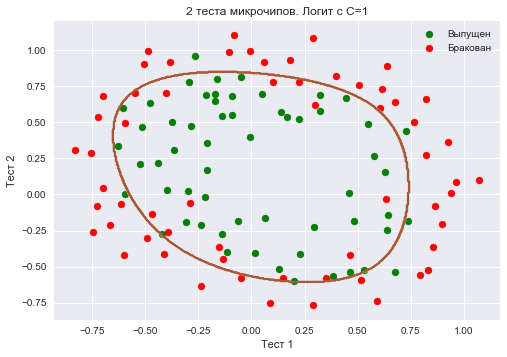

In [11]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=1')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Еще увеличим $C$ – до 10 тысяч. Теперь регуляризации явно недостаточно, и мы наблюдаем переобучение. Можно заметить, что в прошлом случае (при $C$=1 и "гладкой" границе) доля правильных ответов модели на обучающей выборке не намного ниже, чем в 3 случае, зато на новой выборке, можно себе представить, 2 модель сработает намного лучше. 

Доля правильных ответов классификатора на обучающей выборке: 0.873


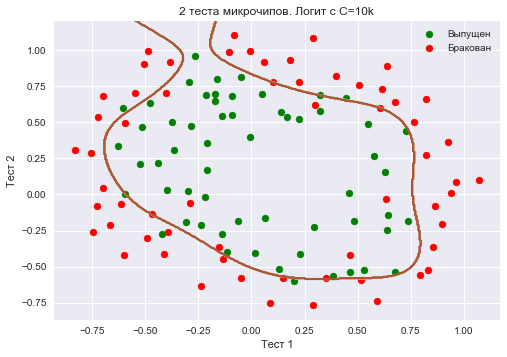

In [12]:
C = 1e4
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=10k')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(logit.score(X_poly, y), 3))

Чтоб обсудить результаты, перепишем формулу для функционала, который оптимизируется в логистической регрессии, в таком виде:
$$J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

где
 - $\mathcal{L}$ – логистическая функция потерь, просуммированная по всей выборке
 - $C$ – обратный коэффициент регуляризации (тот самый $C$ в `sklearn`-реализации `LogisticRegression`)

**Промежуточные выводы**:
 - чем больше параметр $C$, тем более сложные зависимости в данных может восстанавливать модель (интуитивно $C$ соответствует "сложности" модели (model capacity))
 - если регуляризация слишком сильная (малые значения $C$), то решением задачи минимизации логистической функции потерь может оказаться то, когда многие веса занулились или стали слишком малыми. Еще говорят, что модель недостаточно "штрафуется" за ошибки (то есть в функционале $J$ "перевешивает" сумма квадратов весов, а ошибка $\mathcal{L}$ может быть относительно большой). В таком случае модель окажется *недообученной* (1 случай)
 - наоборот, если регуляризация слишком слабая (большие значения $C$), то решением задачи оптимизации может стать вектор $w$ с большими по модулю  компонентами. В таком случае больший вклад в оптимизируемый функционал $J$ имеет  $\mathcal{L}$ и, вольно выражаясь, модель слишком "боится" ошибиться на объектах обучающей выборки, поэтому окажется *переобученной* (3 случай)
 - то, какое значение $C$ выбрать, сама логистическая регрессия "не поймет" (или еще говорят "не выучит"), то есть это не может быть определено решением оптимизационной задачи, которой является логистическая регрессия (в отличие от весов $w$). Так же точно, дерево решений не может "само понять", какое ограничение на глубину выбрать (за один процесс обучения). Поэтому $C$ – это *гиперпараметр* модели, который настраивается на кросс-валидации, как и *max_depth* для дерева.

**Настройка параметра регуляризации**

Теперь найдем оптимальное (в данном примере) значение параметра регуляризации $C$. Сделать это можно с помощью `LogisticRegressionCV` – перебора параметров по сетке с последующей кросс-валидацией. Этот класс создан специально для логистической регрессии (для нее известны эффективные алгоритмы перебора параметров), для произвольной модели мы бы использовали `GridSearchCV`, `RandomizedSearchCV` или, например, специальные алгоритмы оптимизации гиперпараметров, реализованные в `hyperopt`.

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


LogisticRegressionCV(Cs=array([  1.00000e-02,   1.02334e-02, ...,   9.77192e+02,   1.00000e+03]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=1)

In [20]:
logit_searcher.C_

array([ 5.43839743])

Посмотрим, как качество модели (доля правильных ответов на обучающей и валидационной выборках) меняется при изменении гиперпараметра $C$. 

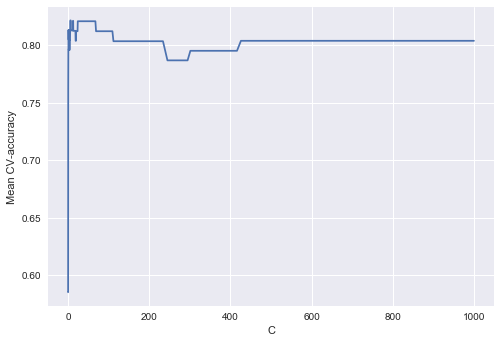

In [31]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

Выделим участок с "лучшими" значениями C.

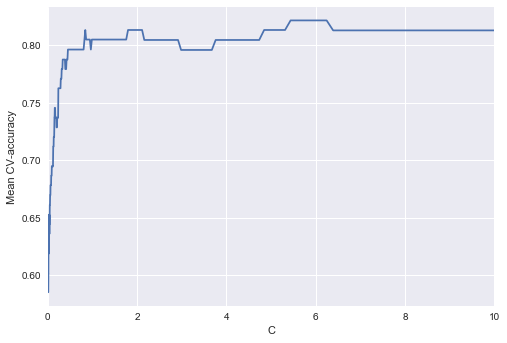

In [36]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.xlim((0,10));

Такие кривые называются *валидационными*, и в `sklearn` для них их построения есть специальные методы.